<a href="https://colab.research.google.com/github/safanisna/datascientest-ocr/blob/main/DataScientest_Safan_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets
!pip install opencv-python
!pip install pytesseract
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import opendatasets as od
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from matplotlib import image as mpimg

Downloading datasets from kaggle using opendatasets (need kaggle account to provide kaggle credentials)

In [ ]:
od.download('https://www.kaggle.com/datasets/manishthem/text-extraction-for-ocr')

Skipping, found downloaded files in "./text-extraction-for-ocr" (use force=True to force download)


# Datasets
Below are the given description regarding the dataset.

> ### About Dataset
> #### Context
Typical NER will identify various entities in the text but not every name come with proper context. The data set provides structured data in the XML format and requires its users to extract various entities.
> #### Content
The data set consist of XML files and images. The XML files contain the extracted data from the image of the invoices, name of text and XML file is kept the same for clarity. Users of the dataset should extract entities like invoice no, invoice data, company name (invoice from company1 to company2/person), telephone number of the company, address e.t.c
> #### Acknowledgements
We wouldn't be here without the help of others. If you owe any attributions or thanks, include them here along with any citations of past research.
> #### Inspiration
Challenges: <br>
Invoices data contains tabular data, which is challenging to deal with. Design a methodology to extract information from tabular data.
Due to obvious reasons, certain numbers in XML are erroneous for eg, '0' replaced by 'O'.

## Understanding the Data
Find dataset using `os` package to see the completeness of datasets.

In [ ]:
import os
path_ = '/content/text-extraction-for-ocr/ImageAndXML_Data'

In [ ]:
# dataset path

filepath = path_ + '/'
del path_

### Completeness checking
To check whether we have all the neccessary files

In [ ]:
# counting number of files inside the dataset
# counting the completeness of each image file

nfiles = 0

# Initializing filename, gt, ocr file as a checklist

tifs, gts, ocrs, oths = [], [], [], []


for i, file in enumerate(os.listdir(filepath)):
    nfiles += 1
    if i < 10:
        print(os.path.join('/', file))
    if file.endswith('.tif'):
        tifs.append(file)
    elif file.endswith('_gt.xml'):
        gts.append(file)
    elif file.endswith('_ocr.xml'):
        ocrs.append(file)
    else:
        oths.append(file)

print('\n')
print('There are total', nfiles, 'number of files in the data')

/00922240_ocr.xml
/92185588.tif
/0060181312_ocr.xml
/2085699682_ocr.xml
/80233716.tif
/83565318_gt.xml
/2085529729.tif
/2001213573_gt.xml
/2073883306.tif
/ti16310336_ocr.xml


There are total 1561 number of files in the data


If we look at the filename above. All filename are assumed to be formatted this way:
1. xx.tif as the image
2. xx_gt.xml as the 1st xml
3. xx_ocr.xml as the 2nd xml

The xx will then called as `image_id`

Referring to the description: <br> <b> The XML files contain the extracted data from the image of the invoices, name of text and XML file is kept the same for clarity. </b>

In [ ]:
print('#file formatted .tif:', len(tifs))
print('#file formatted _gt.xml:', len(gts))
print('#file formatted _ocr.xml:', len(ocrs))

#file formatted .tif: 520
#file formatted _gt.xml: 520
#file formatted _ocr.xml: 520


In [ ]:
all_files = tifs + gts + ocrs
ids = [i.replace('.tif', '').replace('_gt.xml','').replace('_ocr.xml','') for i in all_files]
ids = list(set(ids))

print('#image id:', len(ids))

#image id: 520


In [ ]:
# file completeness check

a = [0] * len(ids)
tifs_ = a.copy()
gts_ = a.copy()
ocrs_ = a.copy()

for i,id_ in enumerate(ids):
    _tif = str(id_) + '.tif'
    _gt = str(id_) + '_gt.xml'
    _ocr = str(id_) + '_ocr.xml'
    if i < 10:
        if _tif in tifs:
            tifs_[i] = 1
        if _gt in gts:
            gts_[i] = 1
        if _ocr in ocrs:
            ocrs_[i] = 1

In [ ]:
ids, tifs, gts, ocrs = sorted(ids), sorted(tifs), sorted(gts), sorted(ocrs)

df1 = pd.DataFrame({'id': ids, '.tif':tifs, '_gt.xml':gts, '_ocr.xml':ocrs})
df1.tail()

id                 .tif                 _gt.xml  \
515       ti17120992       ti17120992.tif       ti17120992_gt.xml   
516  ti31149327_9330  ti31149327_9330.tif  ti31149327_9330_gt.xml   
517       ti31689113       ti31689113.tif       ti31689113_gt.xml   
518       ti31689150       ti31689150.tif       ti31689150_gt.xml   
519      tob02910.64      tob02910.64.tif      tob02910.64_gt.xml   

                    _ocr.xml  
515       ti17120992_ocr.xml  
516  ti31149327_9330_ocr.xml  
517       ti31689113_ocr.xml  
518       ti31689150_ocr.xml  
519      tob02910.64_ocr.xml

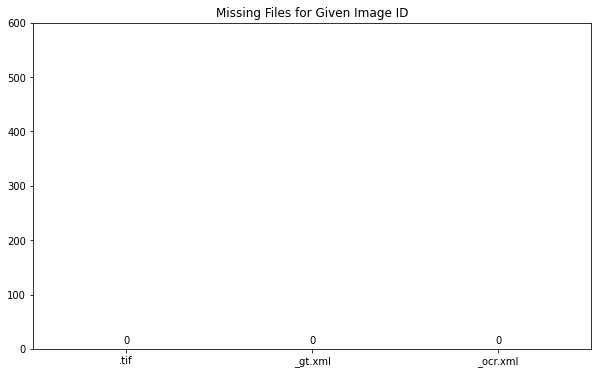

In [ ]:
nrow = df1.shape[0]
ct = df1.isna().sum()[1:]

f, ax = plt.subplots(1,1, figsize=(10, 6))
ct.plot(kind='bar', ax=ax)
ax.set_ylim([0, 600])
ax.set_xticklabels(ct.index, rotation = 0)
ax.set_title('Missing Files for Given Image ID')

for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
# f, ax = plt.gcf(), plt.

<b> From the dataframe above, it's safe to conclude that each image_id has `.tif`, `_gt.xml`, and `_ocr.xml` files. </b>

### What is the data look like?
See what we are dealing with in this document extraction dataset

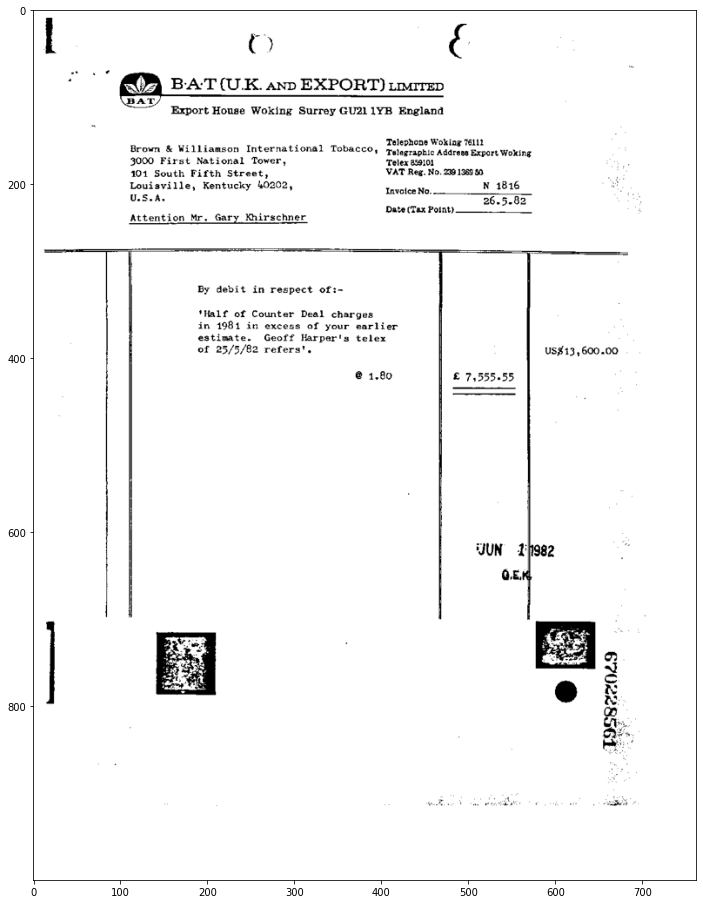

In [ ]:
fn = '0000223278.tif'
fn = filepath + fn
image = mpimg.imread(fn)
plt.imshow(image, cmap='gray')
f = plt.gcf()
f.set_size_inches(24.5, 16)
plt.show()

In [ ]:
img_shape=[]
img_size=[]

for i in tifs:
    image = mpimg.imread(filepath +  i)
    img_shape.append(image.shape)
    img_size.append(image.size)

In [ ]:
df_list = list(zip(ids,tifs,ocrs,gts,img_size,img_shape))
df = pd.DataFrame(df_list, columns=['ids','tif','ocr','gt','size','shape'])
df.head()

ids             tif                 ocr                 gt    size  \
0  0000223278  0000223278.tif  0000223278_ocr.xml  0000223278_gt.xml  762000   
1  0001136521  0001136521.tif  0001136521_ocr.xml  0001136521_gt.xml  762000   
2  0001139626  0001139626.tif  0001139626_ocr.xml  0001139626_gt.xml  762000   
3  0001139716  0001139716.tif  0001139716_ocr.xml  0001139716_gt.xml  762000   
4  0001144288  0001144288.tif  0001144288_ocr.xml  0001144288_gt.xml  762000   

         shape  
0  (1000, 762)  
1  (1000, 762)  
2  (1000, 762)  
3  (1000, 762)  
4  (1000, 762)

In [ ]:
df['height'] = df['shape'].apply(lambda x: x[0])
df['width'] = df['shape'].apply(lambda x: x[1])

df.head()

ids             tif                 ocr                 gt    size  \
0  0000223278  0000223278.tif  0000223278_ocr.xml  0000223278_gt.xml  762000   
1  0001136521  0001136521.tif  0001136521_ocr.xml  0001136521_gt.xml  762000   
2  0001139626  0001139626.tif  0001139626_ocr.xml  0001139626_gt.xml  762000   
3  0001139716  0001139716.tif  0001139716_ocr.xml  0001139716_gt.xml  762000   
4  0001144288  0001144288.tif  0001144288_ocr.xml  0001144288_gt.xml  762000   

         shape  height  width  
0  (1000, 762)    1000    762  
1  (1000, 762)    1000    762  
2  (1000, 762)    1000    762  
3  (1000, 762)    1000    762  
4  (1000, 762)    1000    762

In [ ]:
df.columns

Index(['ids', 'tif', 'ocr', 'gt', 'size', 'shape', 'height', 'width'], dtype='object')

Text(0.5, 1.0, 'Width of the Documents')

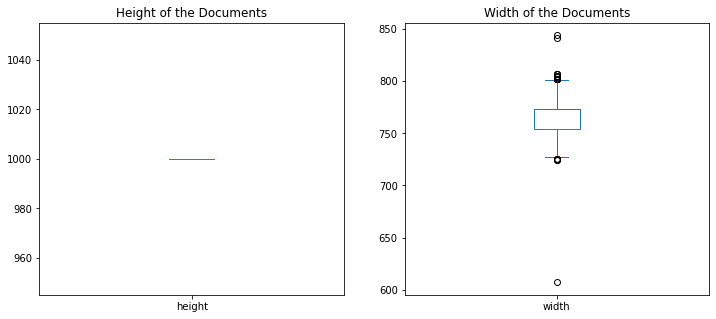

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
df['height'].plot(kind='box', ax=ax[0])
df['width'].plot(kind='box', ax=ax[1])
ax[0].set_title('Height of the Documents')
ax[1].set_title('Width of the Documents')

From the graph above, we can see that the image documents dataset have standard length of 1000 px and variative width ranging from 600 - 850 px.

## Preprocess the Data
Perform a preprocessing activities to prepare the image data. <br>
Source: [Pre-Processing in OCR!!!](https://towardsdatascience.com/pre-processing-in-ocr-fc231c6035a7)

In [ ]:
import cv2
import easyocr

In [ ]:
# add folder temp as a saved image from preprocessing steps
temp_path = filepath + 'temp'
if not os.path.exists(temp_path):
    os.makedirs(temp_path)
temp_path = temp_path + '/'

In [ ]:
# trying to preprocess just a fraction of all the image dataset

dfs = df.sample(n=50, random_state=70).reset_index(drop=True)
dfs.head()

ids                  tif                      ocr  \
0       ti16310260       ti16310260.tif       ti16310260_ocr.xml   
1       2028726871       2028726871.tif       2028726871_ocr.xml   
2       2070424009       2070424009.tif       2070424009_ocr.xml   
3  ti15358056_8057  ti15358056_8057.tif  ti15358056_8057_ocr.xml   
4         80233633         80233633.tif         80233633_ocr.xml   

                       gt    size        shape  height  width  
0       ti16310260_gt.xml  754000  (1000, 754)    1000    754  
1       2028726871_gt.xml  777000  (1000, 777)    1000    777  
2       2070424009_gt.xml  754000  (1000, 754)    1000    754  
3  ti15358056_8057_gt.xml  754000  (1000, 754)    1000    754  
4         80233633_gt.xml  754000  (1000, 754)    1000    754

In [ ]:
reader = easyocr.Reader(['en'])
fn_ = 'ti15358056_8057.tif'
img_ = mpimg.imread(filepath + fn_)

result = reader.readtext(img_)

In [ ]:
result

[([[222, 155], [498, 155], [498, 186], [222, 186]],
  'P.JMiller Law Offices, P.A',
  0.8694433280379246),
 ([[315, 191], [413, 191], [413, 209], [315, 209]],
  'Attn:  Accounting',
  0.7606138742783116),
 ([[325, 209], [405, 209], [405, 223], [325, 223]],
  'P.0. Box [46',
  0.2653804783164227),
 ([[297, 223], [433, 223], [433, 239], [297, 239]],
  'Baldwin WI 54002-0146',
  0.6638937961691156),
 ([[543, 241], [643, 241], [643, 257], [543, 257]],
  '715-684-4344 WI',
  0.7350370452447377),
 ([[91, 263], [209, 263], [209, 277], [91, 277]],
  'Invoice submitted to:',
  0.530069945041415),
 ([[543, 259], [647, 259], [647, 275], [543, 275]],
  '612-222-3949 MN',
  0.9182447951803117),
 ([[91, 287], [299, 287], [299, 303], [91, 303]],
  'Tobacco Litigation Liaison Counsel',
  0.9165814360836388),
 ([[91, 301], [321, 301], [321, 319], [91, 319]],
  'ROBINS, KAPLAN, MILLER & CIREST:',
  0.47306599180443),
 ([[93, 321], [123, 321], [123, 333], [93, 333]], 'Attn:', 0.919150140226337),
 ([[127,

In [ ]:
result[0]

([[222, 155], [498, 155], [498, 186], [222, 186]],
 'P.JMiller Law Offices, P.A',
 0.8694433280379246)

In [ ]:
def show_image(filename, path=filepath, fig_size=(24.5, 16)):
  fn = filepath + filename
  image = mpimg.imread(fn)
  plt.imshow(image, cmap='gray')
  f = plt.gcf()
  f.set_size_inches(fig_size)
  plt.show()
  return None

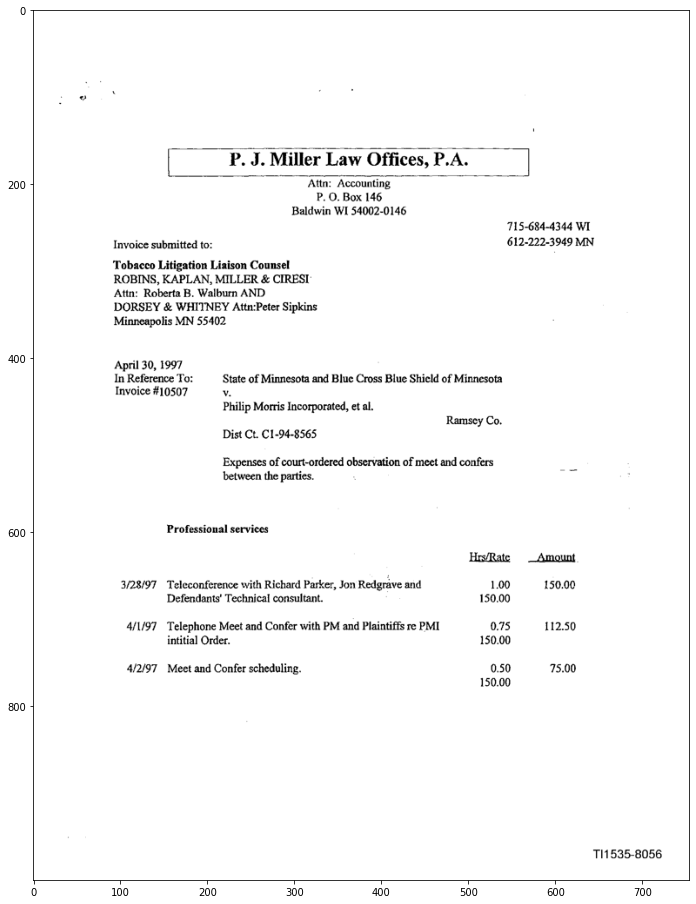

In [ ]:
show_image(fn_)

In [ ]:
reader = easyocr.Reader(['en'])
img_number = 1
dfr = pd.DataFrame(columns = ['image_id', ''])
img_ids_, results_ = list(), list()
# len_ = []

for ix, fn_ in enumerate(dfs['tif']):
  print(ix, fn_)
  img_ids_.append(fn_.replace('.tif', ''))
  im = mpimg.imread(filepath + '/' + fn_)
  results_.append(reader.readtext(im))
  img_number +=1

0 ti16310260.tif
1 2028726871.tif
2 2070424009.tif
3 ti15358056_8057.tif
4 80233633.tif
5 2029370804.tif
6 2073684118.tif


KeyboardInterrupt: ignored

In [ ]:
dfr = pd.DataFrame({'image_id': img_ids_, 'result': results_})

In [ ]:
dfr.head()

image_id                                             result
0       ti16310260  [([[203, 109], [281, 109], [281, 123], [203, 1...
1       2028726871  [([[590, 63], [653, 63], [653, 90], [590, 90]]...
2       2070424009  [([[211, 91], [279, 91], [279, 129], [211, 129...
3  ti15358056_8057  [([[222, 155], [498, 155], [498, 186], [222, 1...
4         80233633  [([[116, 114], [296, 114], [296, 144], [116, 1...

In [ ]:
def get_ocr_result(ocr_result, get, in_np_array=False):
  """
  get 'score', or 'bbox' (box position), or 'text'
  """
  getlist = ['bbox', 'text', 'score']
  getdict = {c:i for i,c in enumerate(getlist)}
  gd = getdict[get]
  get_result = [t[gd] for t in ocr_result]
  if in_np_array:
    get_result = np.array(get_result)
  return get_result

In [ ]:
dfr['score'] = dfr['result'].apply(lambda x: get_ocr_result(x, 'score', True).mean())

In [ ]:
dfr

image_id                                             result  \
0              ti16310260  [([[203, 109], [281, 109], [281, 123], [203, 1...   
1              2028726871  [([[590, 63], [653, 63], [653, 90], [590, 90]]...   
2              2070424009  [([[211, 91], [279, 91], [279, 129], [211, 129...   
3         ti15358056_8057  [([[222, 155], [498, 155], [498, 186], [222, 1...   
4                80233633  [([[116, 114], [296, 114], [296, 144], [116, 1...   
5              2029370804  [([[13, 31], [91, 31], [91, 49], [13, 49]], Ma...   
6              2073684118  [([[47, 73], [118, 73], [118, 97], [47, 97]], ...   
7              0060053761  [([[13, 5], [35, 5], [35, 19], [13, 19]], Cc:,...   
8              2077000123  [([[59, 81], [253, 81], [253, 97], [59, 97]], ...   
9              2073883308  [([[281, 97], [465, 97], [465, 117], [281, 117...   
10             2085540620  [([[125, 193], [411, 193], [411, 211], [125, 2...   
11             ti16311156  [([[205, 103], [283, 103], [283, 117], [205, 1...   
12               96063504  [([[75, 95], [145, 95], [145, 111], [75, 111]]...   
13             2047260303  [([[447, 53], [709, 53], [709, 71], [447, 71]]...   
14             2063846615  [([[298, 84], [446, 84], [446, 108], [298, 108...   
15             2084022300  [([[75, 93], [237, 93], [237, 109], [75, 109]]...   
16             2041158049  [([[66, 104], [177, 104], [177, 158], [66, 158...   
17             1000031514  [([[164, 178], [347, 178], [347, 195], [164, 1...   
18             0060060466  [([[467, 171], [515, 171], [515, 187], [467, 1...   
19             2065216982  [([[331, 83], [567, 83], [567, 125], [331, 125...   
20          83542445_2446  [([[244, 100], [483, 100], [483, 139], [244, 1...   
21             2063610071  [([[251, 41], [369, 41], [369, 57], [251, 57]]...   
22             2072957848  [([[497, 75], [585, 75], [585, 89], [497, 89]]...   
23               93118029  [([[346, 98], [453, 98], [453, 130], [346, 130...   
24              507053446  [([[222, 94], [271, 94], [271, 114], [222, 114...   
25              506413423  [([[567, 93], [634, 93], [634, 120], [567, 120...   
26              501149455  [([[61, 155], [241, 155], [241, 199], [61, 199...   
27             0060060439  [([[523, 61], [585, 61], [585, 77], [523, 77]]...   
28               92243549  [([[323, 81], [453, 81], [453, 97], [323, 97]]...   
29               82867969  [([[433, 243], [479, 243], [479, 281], [433, 2...   
30               86462803  [([[302, 176], [398, 176], [398, 200], [302, 2...   
31             2071413111  [([[161, 189], [213, 189], [213, 203], [161, 2...   
32             2063250015  [([[497, 153], [581, 153], [581, 169], [497, 1...   
33             2080972555  [([[137, 97], [611, 97], [611, 139], [137, 139...   
34             0060095738  [([[44, 66], [252, 66], [252, 94], [44, 94]], ...   
35        503918489+-8489  [([[88, 86], [138, 86], [138, 118], [88, 118]]...   
36        2505123539_3542  [([[69, 71], [149, 71], [149, 85], [69, 85]], ...   
37    518029843_518029864  [([[37, 17], [175, 17], [175, 57], [37, 57]], ...   
38             2044348020  [([[614, 36], [686, 36], [686, 64], [614, 64]]...   
39        518253689+-3695  [([[365, 53], [433, 53], [433, 67], [365, 67]]...   
40               83644925  [([[290, 82], [426, 82], [426, 112], [290, 112...   
41      00043445_00043449  [([[1, 57], [131, 57], [131, 73], [1, 73]], NV...   
42             2071557502  [([[77, 71], [157, 71], [157, 85], [77, 85]], ...   
43        500125099+-5100  [([[63, 93], [217, 93], [217, 113], [63, 113]]...   
44             2063322469  [([[83, 157], [273, 157], [273, 173], [83, 173...   
45  2041597671_2041597672  [([[114, 16], [158, 16], [158, 24], [114, 24]]...   
46               92185588  [([[241, 201], [439, 201], [439, 221], [241, 2...   
47               92204693  [([[104, 62], [140, 62], [140, 86], [104, 86]]...   
48             0013404965  [([[116, 96], [144, 96], [144, 104], [116, 104...   
49               

In [ ]:
dfr['score'].mean()

0.65630362506556

The raw data give us confidence score of around 65.6%

### Binarize
In layman’s terms **Binarization** means converting a coloured image into an image which consists of only black and white pixels (Black pixel value=0 and White pixel value=255). As a basic rule, this can be done by fixing a threshold (normally threshold=127, as it is exactly half of the pixel range 0–255). If the pixel value is greater than the threshold, it is considered as a white pixel, else considered as a black pixel.

Text(0.5, 1.0, 'Binarized Image')

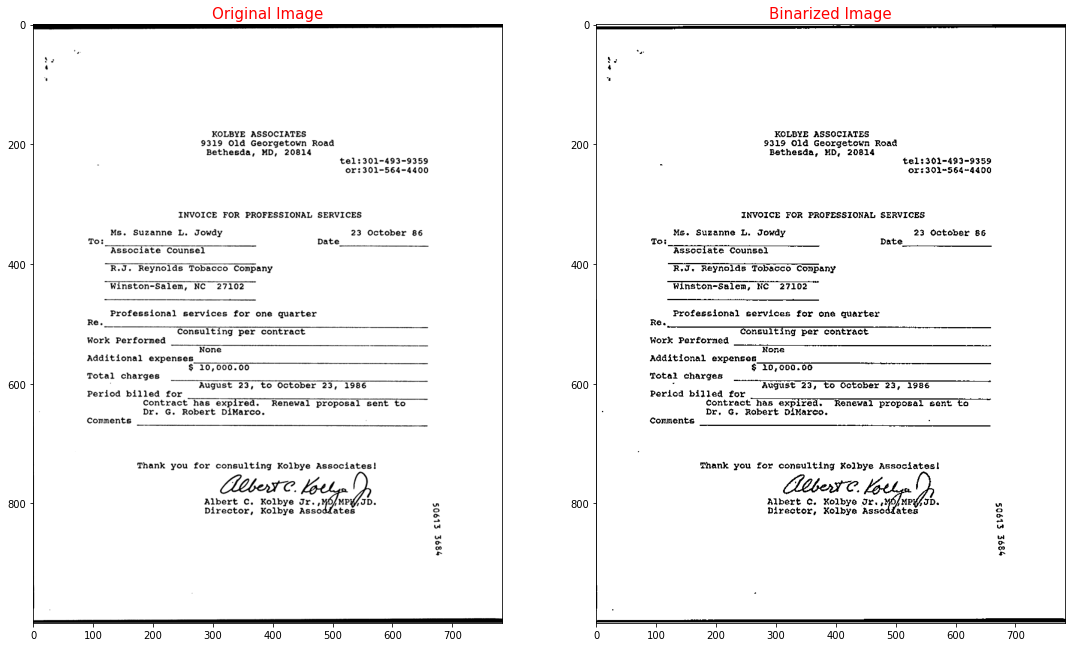

In [ ]:
# binarize using adaptive threshold
fn1 = '506133684.tif'
fn1 = filepath + fn1

img1 = mpimg.imread(fn1)
f,ax = plt.subplots(1, 2, figsize=(18.5, 24))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Original Image', fontsize=15, color='red')

img1_binarize = cv2.adaptiveThreshold(img1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
ax[1].imshow(img1_binarize, cmap='gray')
ax[1].set_title('Binarized Image', fontsize=15, color='red')

Text(0.5, 1.0, 'Binarized Image')

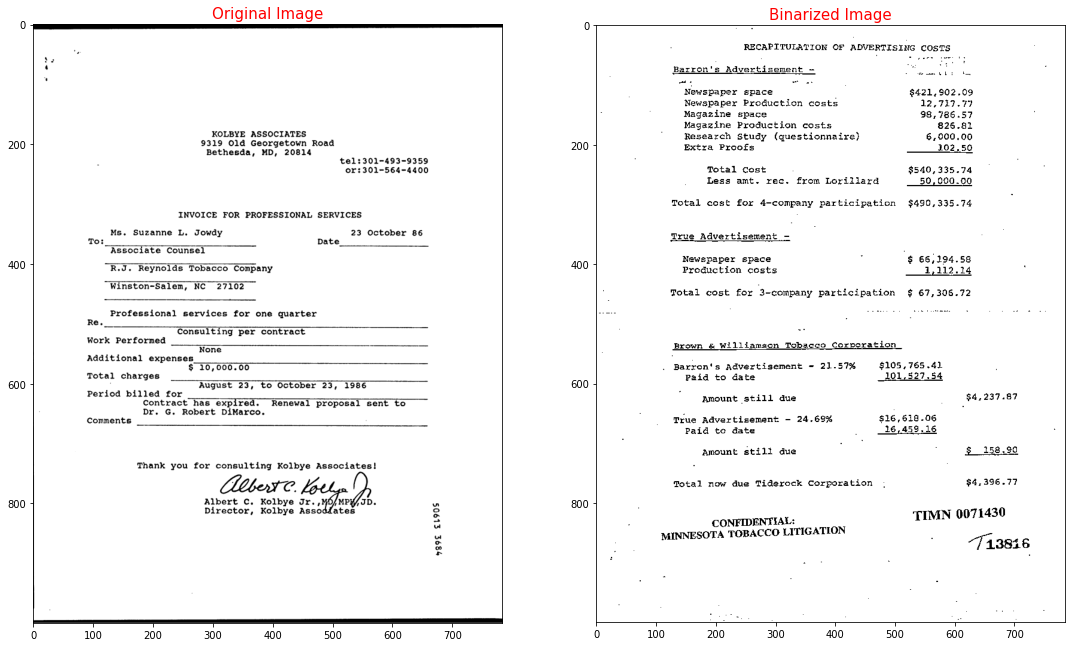

In [ ]:
# binarize using OTSU threshold
fn1 = '506133684.tif'
fn1 = filepath + fn1

img1 = mpimg.imread(fn1)
f,ax = plt.subplots(1, 2, figsize=(18.5, 24))
ax[0].imshow(img1, cmap='gray')
ax[0].set_title('Original Image', fontsize=15, color='red')

# gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img1_binarize = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]

ax[1].imshow(img1_binarize, cmap='gray')
ax[1].set_title('Binarized Image', fontsize=15, color='red')

# gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

In [ ]:
def show_2_images(img1, img2, fig_size=(18.5, 24), img_titles=['Image 1', 'Image 2']):
  f,ax = plt.subplots(1, 2, figsize=fig_size)
  ax[0].imshow(img1, cmap='gray')
  ax[0].set_title(img_titles[0], fontsize=15, color='red')
  ax[1].imshow(img2, cmap='gray')
  ax[1].set_title(img_titles[1], fontsize=15, color='red')
  plt.show()
  return None

In [ ]:
def otsu_binarize(image):
  image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
  return image

def adaptive_binarize(image, block_size=25, c=8):
  image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, block_size, c)
  return image

def simple_binarize(image, threshold=127):
  image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)[1]
  return image

In [ ]:
fn2 = '506133684.tif'
img2 = mpimg.imread(filepath + fn2)
img2_simple_binarize = simple_binarize(img2, 170)
img2_otsu_binarize = otsu_binarize(img2)
img2_adaptive_binarize = adaptive_binarize(img2, 31, 16)
# img2_binarize = cv2.bitwise_not(img2_binarize)

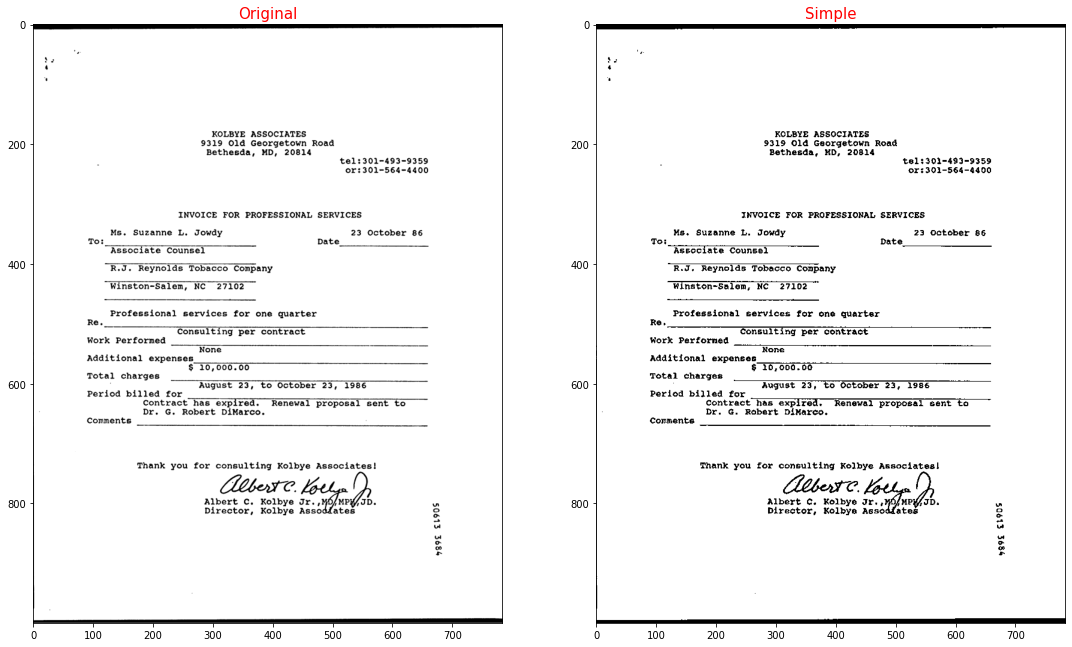

In [ ]:
show_2_images(img2, img2_simple_binarize, img_titles=['Original', 'Simple'], fig_size=(18.5, 24))

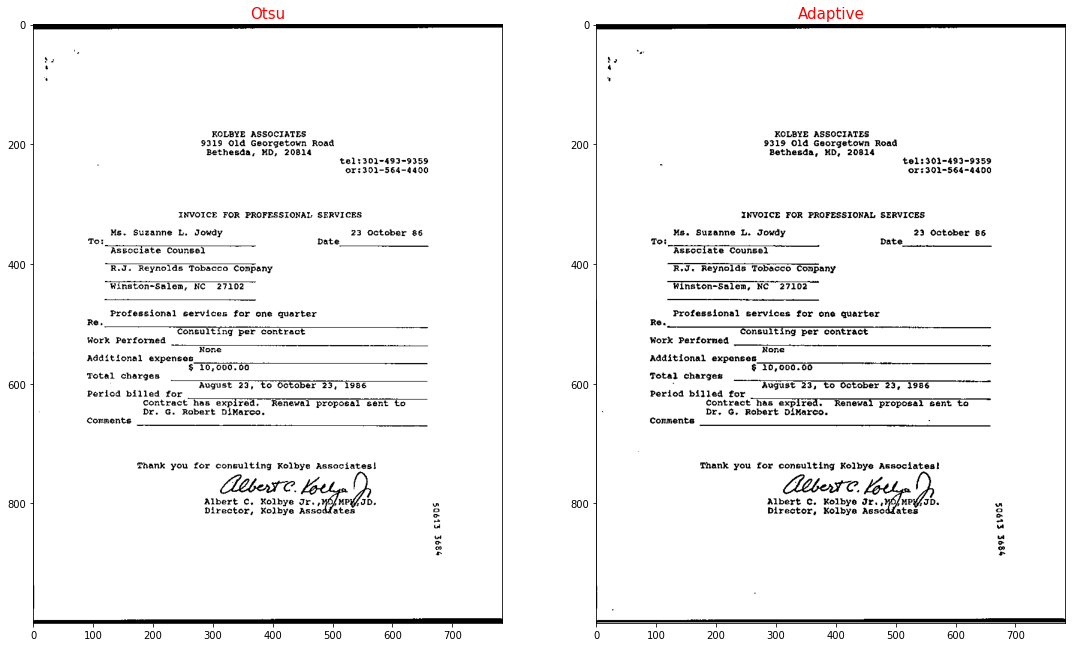

In [ ]:
show_2_images(img2_otsu_binarize, img2_adaptive_binarize, img_titles=['Otsu', 'Adaptive'])

In [ ]:
fn2 = '83542445_2446.tif'
img2 = mpimg.imread(filepath + fn2)
img2_simple_binarize = simple_binarize(img2, 170)
img2_otsu_binarize = otsu_binarize(img2)
img2_adaptive_binarize = adaptive_binarize(img2, 31, 16)
# img2_binarize = cv2.bitwise_not(img2_binarize)

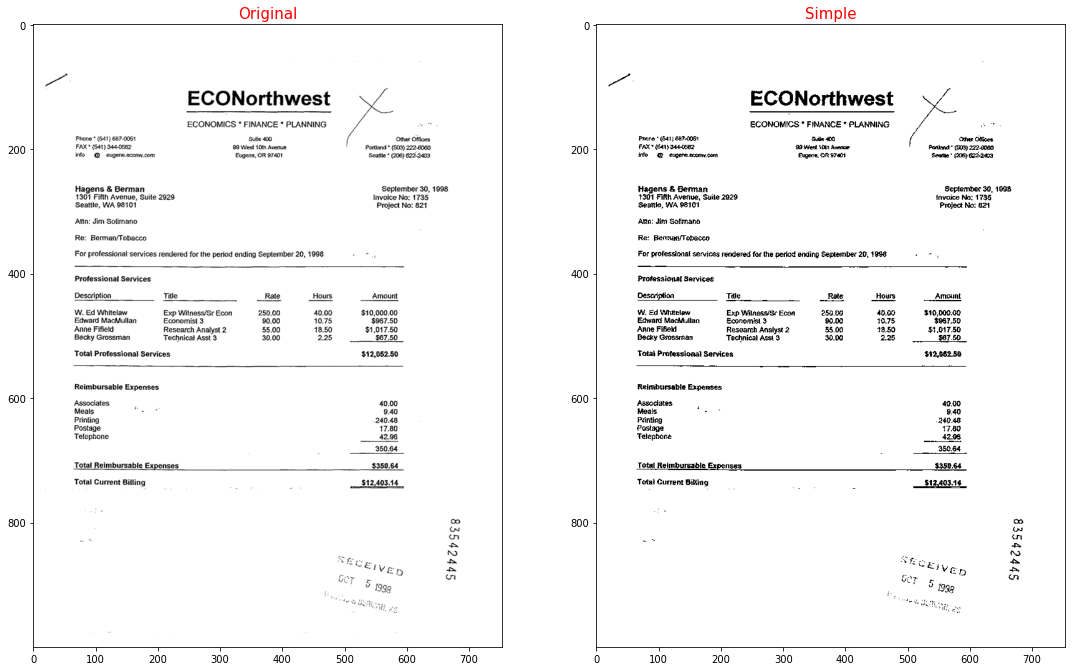

In [ ]:
show_2_images(img2, img2_simple_binarize, img_titles=['Original', 'Simple'], fig_size=(18.5, 24))

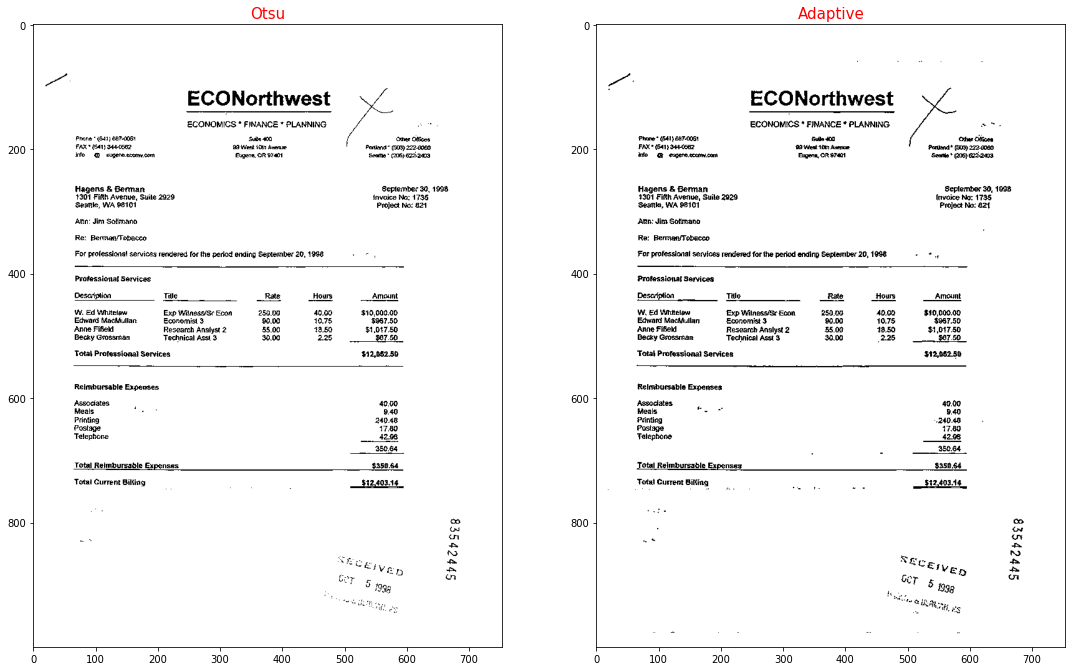

In [ ]:
show_2_images(img2_otsu_binarize, img2_adaptive_binarize, img_titles=['Otsu', 'Adaptive'])

From image above, it's seen that simple has better result compared to Otsu and adaptive threshold

In [ ]:
for i in dfs['tif']:
  fn = filepath + i
  img_ = mpimg.imread(fn)
  img_binarize_ = simple_binarize(img_, 170)
  fn_save = filepath + 'temp/' + i.replace('.tif', '_binarize.tif')
  cv2.imwrite(fn_save, img_binarize_)

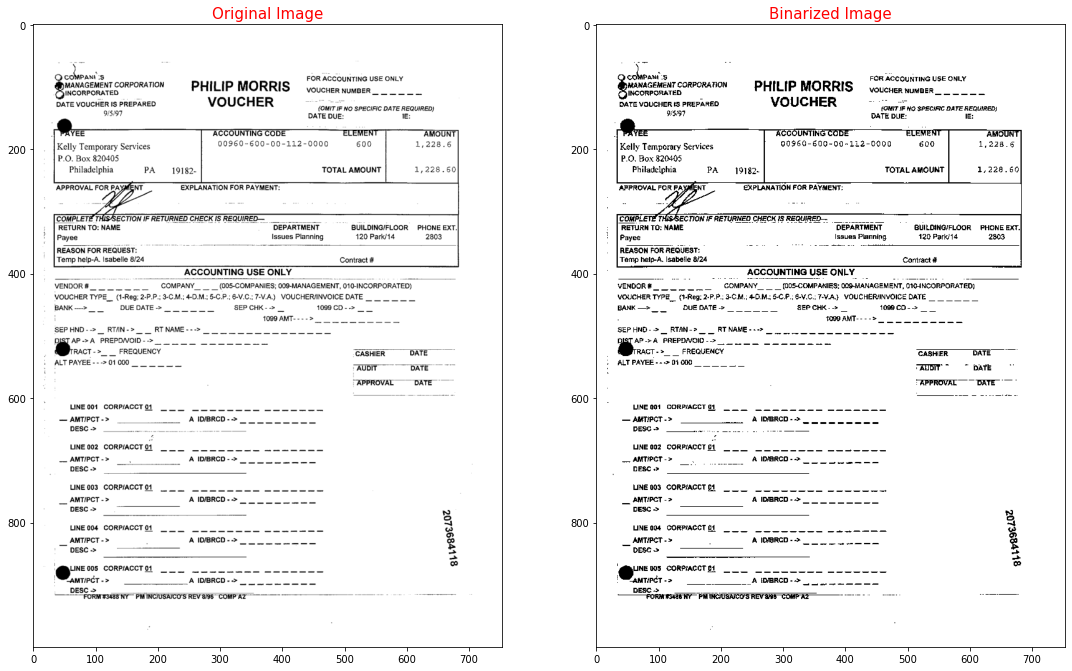

In [ ]:
fn = dfs['tif'].values[6]
img = mpimg.imread(filepath + fn)
fn = temp_path + dfs['tif'].values[6].replace('.tif', '_binarize.tif')
img_binarize = mpimg.imread(fn)

show_2_images(img, img_binarize, img_titles=['Original Image', 'Binarized Image'])

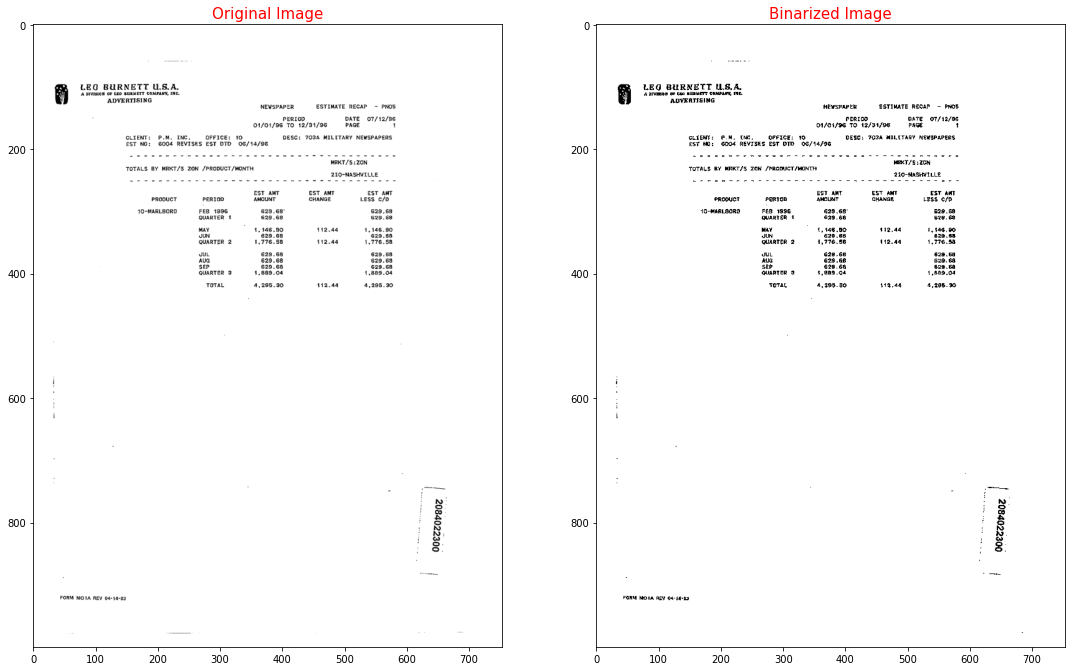

In [ ]:
fn = dfs['tif'].values[15]
img = mpimg.imread(filepath + fn)
fn = temp_path + dfs['tif'].values[15].replace('.tif', '_binarize.tif')
img_binarize = mpimg.imread(fn)

show_2_images(img, img_binarize, img_titles=['Original Image', 'Binarized Image'])

**Preprocessed image above give us a better contrast of the text. However, the font appear to be thicker which is not the best case because it's a bit harder to differentiate each characters due to thickness of the font.**

In [ ]:
dfr.head()

image_id                                             result  \
0       ti16310260  [([[203, 109], [281, 109], [281, 123], [203, 1...   
1       2028726871  [([[590, 63], [653, 63], [653, 90], [590, 90]]...   
2       2070424009  [([[211, 91], [279, 91], [279, 129], [211, 129...   
3  ti15358056_8057  [([[222, 155], [498, 155], [498, 186], [222, 1...   
4         80233633  [([[116, 114], [296, 114], [296, 144], [116, 1...   

      score  
0  0.851138  
1  0.599066  
2  0.737226  
3  0.762517  
4  0.747684

In [ ]:
def read_ocr(data=dfs, column='tif', ocr_reader=reader, path=filepath, process=None):
  img_ids_, results_ = [], []
  for ix, fn_ in enumerate(data['tif']):
    print(ix, fn_)
    img_ids_.append(fn_.replace('.tif', ''))
    if process is not None:
      fn_ = fn_.replace('.tif', '_' + process + '.tif')
    im = mpimg.imread(path + '/' + fn_)
    results_.append(reader.readtext(im))
  dfres = pd.DataFrame({'image_id': img_ids_, 'result': results_})
  return dfres

In [ ]:
#binarize
# dfr1 = read_ocr(data=dfs, column='tif', ocr_reader=reader, path=temp_path, process='binarize')

In [ ]:
# ll = lambda x: get_ocr_result(x, 'score', True).mean()
# dfr1['score'] = dfr1['result'].apply(ll)

In [ ]:
# dfr1['score'].mean()

### Skew Correction
While scanning a document, it might be slightly skewed (image aligned at a certain angle with horizontal) sometimes. While extracting the information from the scanned image, detecting & correcting the skew is crucial.


In [ ]:
from scipy.ndimage import interpolation as inter

In [ ]:
def correct_skew(image, delta=1, limit=5):
    def determine_score(arr, angle):
        data = inter.rotate(arr, angle, reshape=False, order=0)
        histogram = np.sum(data, axis=1, dtype=float)
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2, dtype=float)
        return histogram, score

    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] 

    scores = []
    angles = np.arange(-limit, limit + delta, delta)
    for angle in angles:
        # histogram, score = determine_score(thresh, angle)
        histogram, score = determine_score(image, angle)
        scores.append(score)

    best_angle = angles[scores.index(max(scores))]

    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, best_angle, 1.0)
    corrected = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, \
            borderMode=cv2.BORDER_REPLICATE)

    return best_angle, corrected

In [ ]:
fn

'/content/text-extraction-for-ocr/ImageAndXML_Data/temp/2084022300_binarize.tif'

In [ ]:
angle, img_rotated = correct_skew(img_binarize)

<ipython-input-52-9179e5406b2f>:3: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


In [ ]:
angle

0

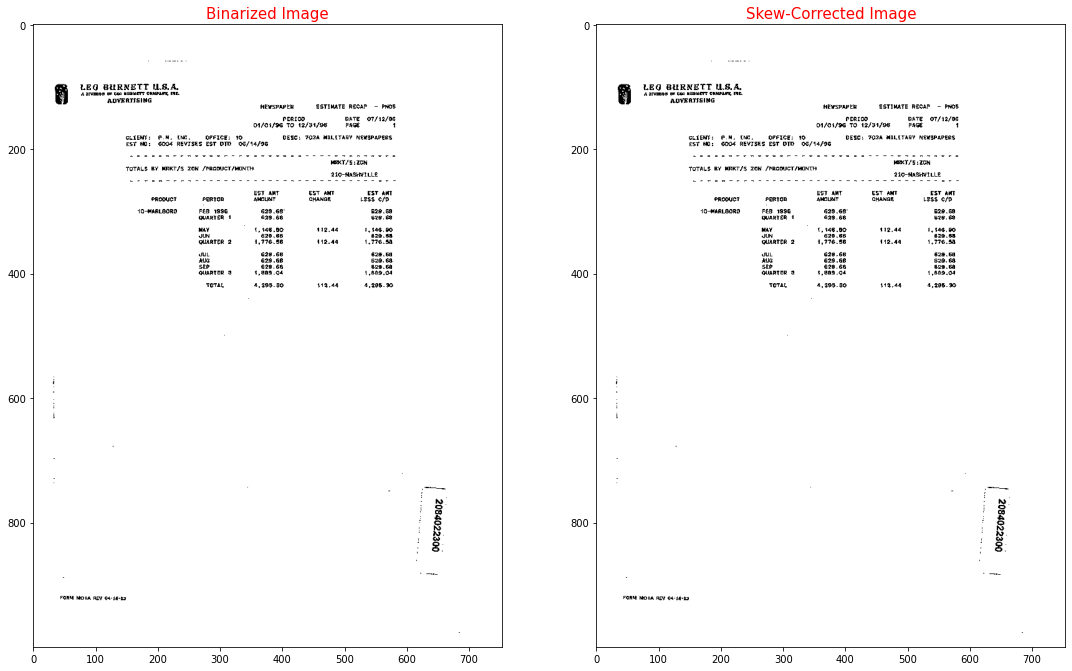

In [ ]:
show_2_images(img_binarize, img_rotated, img_titles=['Binarized Image', 'Skew-Corrected Image'])

The image above, does not in fact need a skew correction because it's already in the correct angle

In [ ]:
# performing skew correction image to all sample images
angles = []
fns = []

for i in dfs['tif']:
  i = i.replace('.tif', '_binarize.tif')
  fn_ = temp_path + i
  img_ = mpimg.imread(fn_)
  fns.append(i)
  angle_, img_rotate_ = correct_skew(img_)
  angles.append(angle_)
  fn_save = filepath + 'temp/' + i.replace('_binarize.tif', '_rotated.tif')
  cv2.imwrite(fn_save, img_rotate_)

<ipython-input-52-9179e5406b2f>:3: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


In [ ]:
# check rotated image
{k:c for c,k in zip(angles, fns) if c != 0}

{'2029370804_binarize.tif': -1,
 'ti16311156_binarize.tif': -1,
 '93118029_binarize.tif': -1,
 '507053446_binarize.tif': 1,
 '0060095738_binarize.tif': 1,
 '2041597671_2041597672_binarize.tif': -1,
 '92204693_binarize.tif': -1}

Most Image only rotated at max. ±1°

In [ ]:
fn = '2029370804.tif'
img = mpimg.imread(filepath + fn)
img_binarize = mpimg.imread(temp_path + fn.replace('.tif', '_binarize.tif'))
img_rotate = mpimg.imread(temp_path + fn.replace('.tif', '_rotated.tif'))

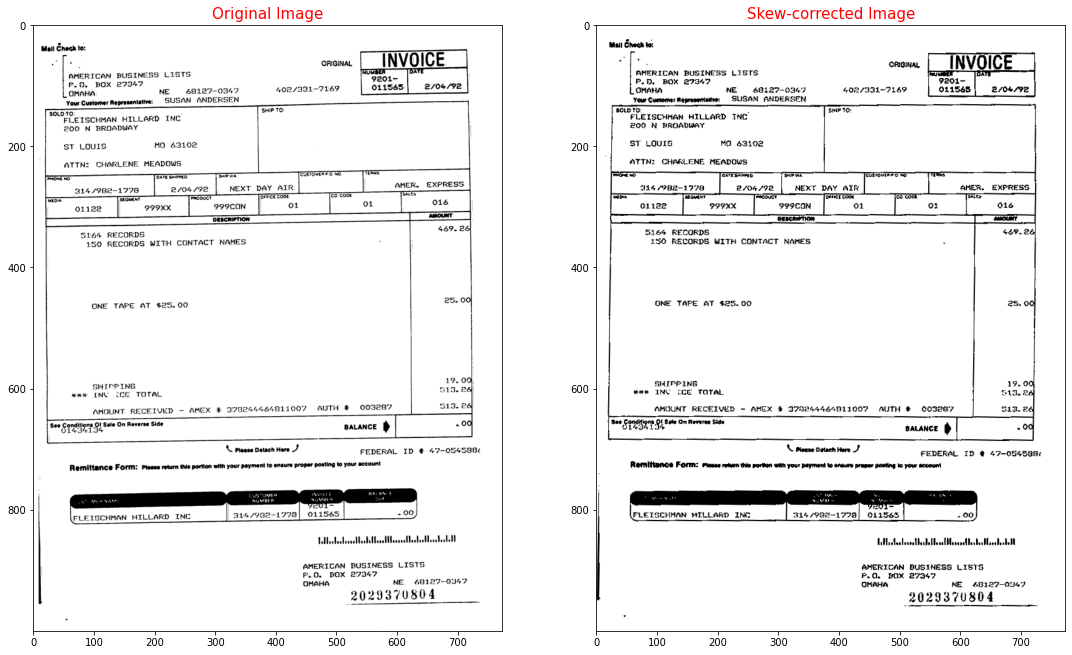

In [ ]:
show_2_images(img, img_rotate, fig_size=(18.5, 24), img_titles=['Original Image', 'Skew-corrected Image'])

### [Morphological Transformations](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html)
Morphological transformations are some simple operations based on the image shape. It is normally performed on binary images. It needs two inputs, one is our original image, second one is called structuring element or kernel which decides the nature of operation. Two basic morphological operators are Erosion and Dilation. Then its variant forms like Opening, Closing, Gradient etc also comes into play.




In [ ]:
def noise_removal(image, method='gaussian', kz=(1,1), blur=3):
  kernel = np.ones((1,1), np.uint8)
  image = cv2.dilate(image, kernel, iterations=1)
  image = cv2.erode(image, kernel, iterations=1)
  image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
  if method == 'gaussian':
    image = cv2.GaussianBlur(image, kz, 0)
  elif method == 'median':
    image = cv2.medianBlur(image, blur)
  return image

In [ ]:
img_nr_gauss = noise_removal(img_rotate, method='gaussian', kz=(3,3))
img_nr_median = noise_removal(img_rotate, method='median')

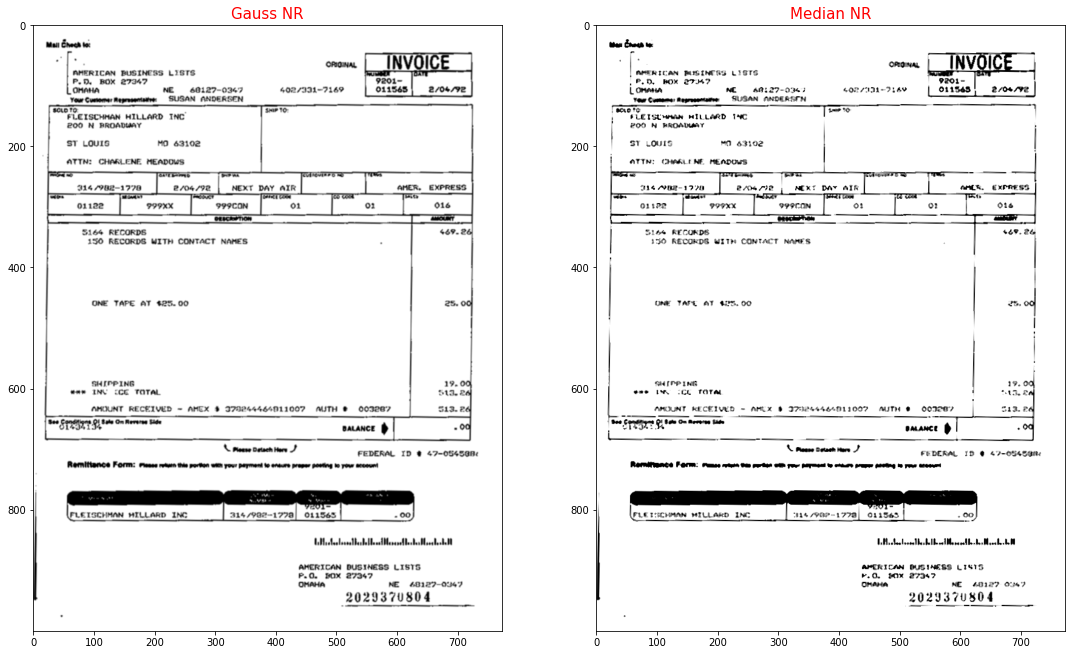

In [ ]:
show_2_images(img_nr_gauss, img_nr_median, fig_size=(18.5, 24), img_titles=['Gauss NR', 'Median NR'])

In [ ]:
dfs.sample(n=5, random_state=1)

ids                  tif                      ocr  \
27       0060060439       0060060439.tif       0060060439_ocr.xml   
35  503918489+-8489  503918489+-8489.tif  503918489+-8489_ocr.xml   
40         83644925         83644925.tif         83644925_ocr.xml   
38       2044348020       2044348020.tif       2044348020_ocr.xml   
2        2070424009       2070424009.tif       2070424009_ocr.xml   

                        gt    size        shape  height  width  
27       0060060439_gt.xml  762000  (1000, 762)    1000    762  
35  503918489+-8489_gt.xml  754000  (1000, 754)    1000    754  
40         83644925_gt.xml  754000  (1000, 754)    1000    754  
38       2044348020_gt.xml  799000  (1000, 799)    1000    799  
2        2070424009_gt.xml  754000  (1000, 754)    1000    754

In [ ]:
fn = '503918489+-8489.tif'
img = mpimg.imread(filepath + fn)
img_binarize = mpimg.imread(temp_path + fn.replace('.tif', '_binarize.tif'))
img_rotate = mpimg.imread(temp_path + fn.replace('.tif', '_rotated.tif'))

In [ ]:
img_nr_gauss = noise_removal(img_rotate, method='gaussian', kz=(5,5))
img_nr_median = noise_removal(img_rotate, method='median')

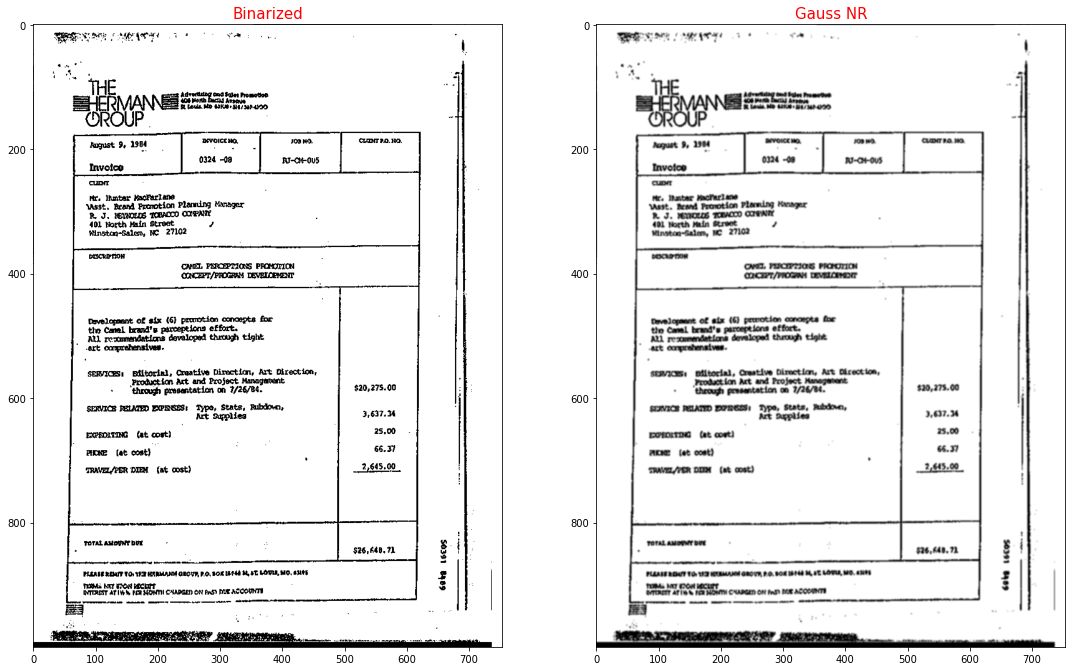

In [ ]:
show_2_images(img_binarize, img_nr_gauss, fig_size=(18.5, 24), img_titles=['Binarized', 'Gauss NR'])

In [ ]:
fn = '2084022300.tif'
img = mpimg.imread(filepath + fn)
img_binarize = mpimg.imread(temp_path + fn.replace('.tif', '_binarize.tif'))
img_rotate = mpimg.imread(temp_path + fn.replace('.tif', '_rotated.tif'))

In [ ]:
img_nr_gauss = noise_removal(img_rotate, method='gaussian', kz=(5,5))
img_nr_median = noise_removal(img_rotate, method='median')

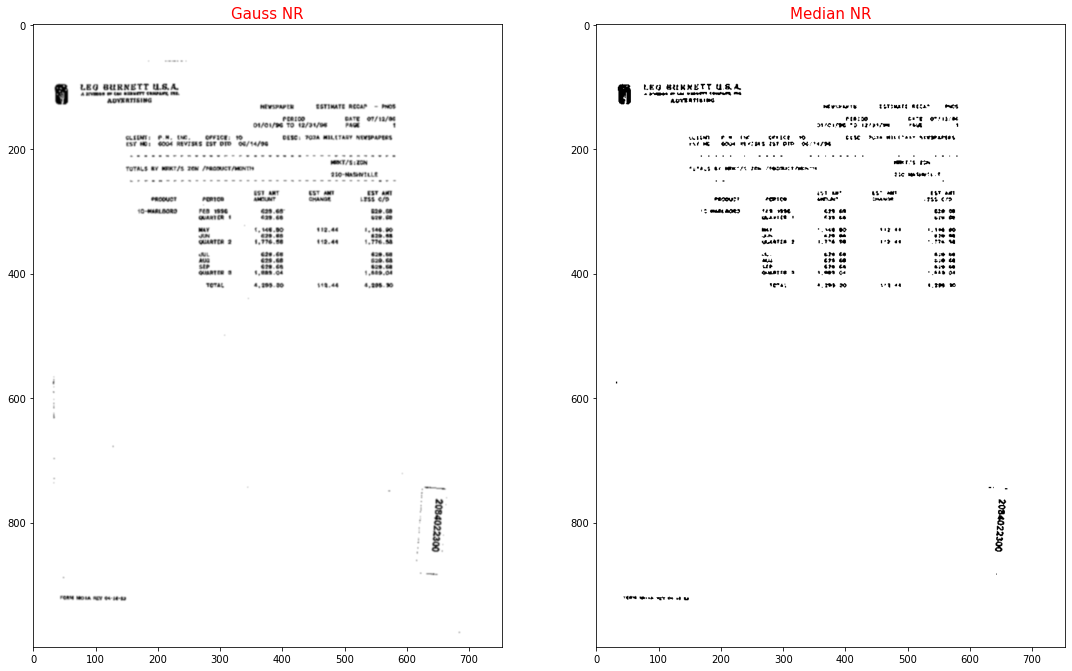

In [ ]:
show_2_images(img_nr_gauss, img_nr_median, fig_size=(18.5, 24), img_titles=['Gauss NR', 'Median NR'])

These images do not need to reduced the image because it costs readibility of the documents.

### [Border Removals](https://stackoverflow.com/questions/33949831/how-to-remove-all-lines-and-borders-in-an-image-while-keeping-text-programmatica)

Removing the page border and table border

In [ ]:
fn = '503918489+-8489.tif'
img = mpimg.imread(filepath + fn)
img_binarize = simple_binarize(img)
_, img_rotate = correct_skew(img_binarize)

<ipython-input-52-9179e5406b2f>:3: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


In [ ]:
# image = cv2.imread(samplefn)
# result = image.copy()
# gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

result = img_rotate.copy()

# Remove horizontal lines
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40,1))
remove_horizontal = cv2.morphologyEx(img_rotate, cv2.MORPH_OPEN, horizontal_kernel, iterations=2)
cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(img_rotate, [c], -1, (255,255,255), 5)

# Remove vertical lines
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
remove_vertical = cv2.morphologyEx(img_rotate, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(result, [c], -1, (255,255,255), 5)

In [ ]:
show_2_images(img_rotate, result)

In [ ]:
def remove_borders(image):
  binary = image
  
  # Find contours
  contours, hierarchy = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

  # Filter out the table contours
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      area = cv2.contourArea(contour)
      aspect_ratio = w / float(h)
      if aspect_ratio > 5 and area > 10000:
          cv2.drawContours(binary, [contour], 0, 0, -1)

  # Create a mask for the remaining text contours
  mask = np.zeros_like(binary)
  for contour in contours:
      x, y, w, h = cv2.boundingRect(contour)
      area = cv2.contourArea(contour)
      aspect_ratio = w / float(h)
      if aspect_ratio <= 5 and area < 10000:
          cv2.drawContours(mask, [contour], 0, 255, -1)

  # Apply the mask to the binary image
  result = cv2.bitwise_and(binary, mask)

  # # Save the resulting image
  # cv2.imwrite('result.png', result)

  return result

In [ ]:
img_rmv_border = remove_borders(img_rotate)

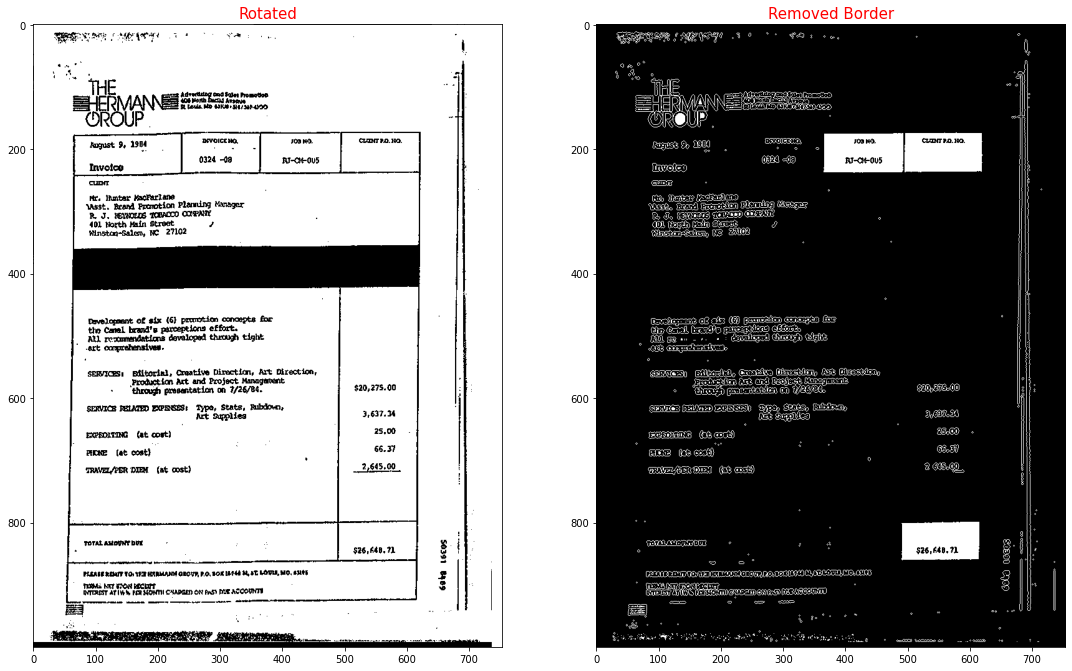

In [ ]:
show_2_images(img_rotate, img_rmv_border, img_titles=['Rotated', 'Removed Border'])

In [ ]:
fn = '2029370804.tif'
img = mpimg.imread(filepath + fn)
img_binarize = mpimg.imread(temp_path + fn.replace('.tif', '_binarize.tif'))
img_rotate = mpimg.imread(temp_path + fn.replace('.tif', '_rotated.tif'))

img_rmv_border = remove_borders(img_rotate)

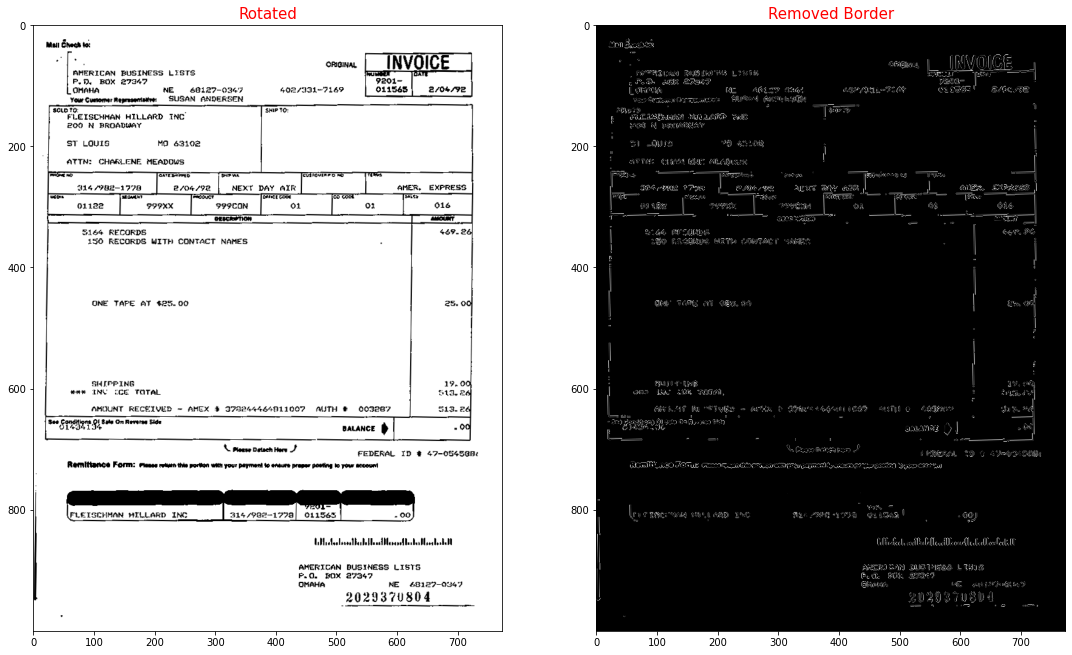

In [ ]:
show_2_images(img_rotate, img_rmv_border, img_titles=['Rotated', 'Removed Border'])

### Resize
Resizing to standard values

Text(0.5, 1.0, 'Width of the Documents')

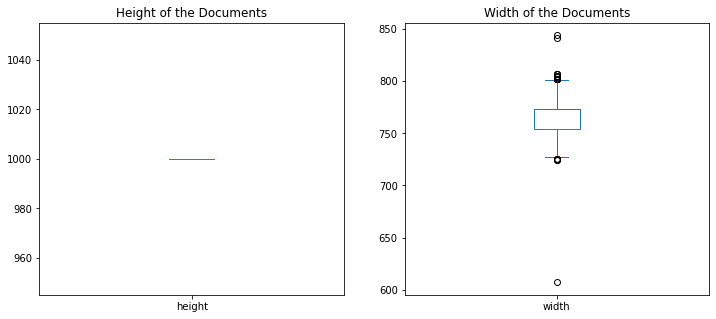

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(12, 5))
df['height'].plot(kind='box', ax=ax[0])
df['width'].plot(kind='box', ax=ax[1])
ax[0].set_title('Height of the Documents')
ax[1].set_title('Width of the Documents')

In [ ]:
df['width'].mean()

763.9115384615385

### Redo the Preprocessing for ALL Images

Performing binarization and rotation preprocessing to make it easier for model. Also, adding process of resize to dimension of 1000x760 pixels.

In [ ]:
# !pip import shutil
print(temp_path)

/content/text-extraction-for-ocr/ImageAndXML_Data/temp/


In [ ]:
import shutil
# temp_path = filepath + 'temp'
if os.path.exists(temp_path):
    shutil.rmtree(temp_path)

In [ ]:
temp_path = filepath + 'temp'
if not os.path.exists(temp_path):
    os.makedirs(temp_path)
temp_path = temp_path + '/'

In [ ]:
angles = []
fns = []
dsize = (765, 1000)

for c, i in enumerate(tifs):
  if c % 10 == 0:
    print(c, i)
  fn = filepath + i
  img_ = mpimg.imread(fn)
  img_binarize_ = adaptive_binarize(img_, 31, 16)
  # fn_save = temp_path + i.replace('.tif', '_binarize.tif')
  # cv2.imwrite(fn_save, img_binarize_)
  fns.append(i)
  angle_, img_rotate_ = correct_skew(img_binarize_)
  angles.append(angle_)
  img_save_ = cv2.resize(img_rotate_, dsize, interpolation = cv2.INTER_AREA)
  # fn_save = filepath + 'temp/' + i.replace('.tif', '_rotated.tif')
  fn_save = filepath + 'temp/' + i.replace('.tif', '_preprocessed.tif')
  cv2.imwrite(fn_save, img_save_)

0 0000223278.tif


<ipython-input-52-9179e5406b2f>:3: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  data = inter.rotate(arr, angle, reshape=False, order=0)


10 0013043193.tif
20 0060027425.tif
30 0060053785.tif
40 0060075996.tif
50 0060088183.tif
60 0060203682.tif
70 00922240.tif
80 11225665.tif
90 11315936.tif
100 2015064568.tif
110 2024476618.tif
120 2028703417.tif
130 2029370464.tif
140 2030138076_2030138077.tif
150 2041063035.tif
160 2041954112.tif
170 2044402070.tif
180 2050760847.tif
190 2063162659.tif
200 2063319693.tif
210 2063611385.tif
220 2065364917.tif
230 2071217429.tif
240 2072957830.tif
250 2074417069.tif
260 2080731237.tif
270 2084021870.tif
280 2084022243.tif
290 2084024707.tif
300 2085699092.tif
310 2501368827.tif
320 500234635+-4635.tif
330 505852048_505852049.tif
340 512981600_512981601.tif
350 514858504_514858506.tif
360 518253165+-3165.tif
370 518492684+-2684.tif
380 80211567.tif
390 82898529.tif
400 83553545.tif
410 86018092.tif
420 86462933.tif
430 87147801.tif
440 91660729.tif
450 92243549.tif
460 93118328.tif
470 99380614.tif
480 ti09922229.tif
490 ti16310336.tif
500 ti16311156.tif
510 ti17120099.tif


In [ ]:
del image, img, img1, img1_binarize, img2, img2_adaptive_binarize, img2_otsu_binarize, img2_simple_binarize, img_, img_binarize, img_binarize_, img_ids_, img_nr_gauss, img_nr_median, img_number, img_rotate, img_rotate_, img_rotated, img_save_, img_shape, img_size
del fn, fn1, fn2, fn_, fn_save, fns

In [ ]:
fn = '0060031745.tif'
img = mpimg.imread(filepath + fn)
img_preprocessed = mpimg.imread(temp_path + fn.replace('.tif', '_preprocessed.tif'))

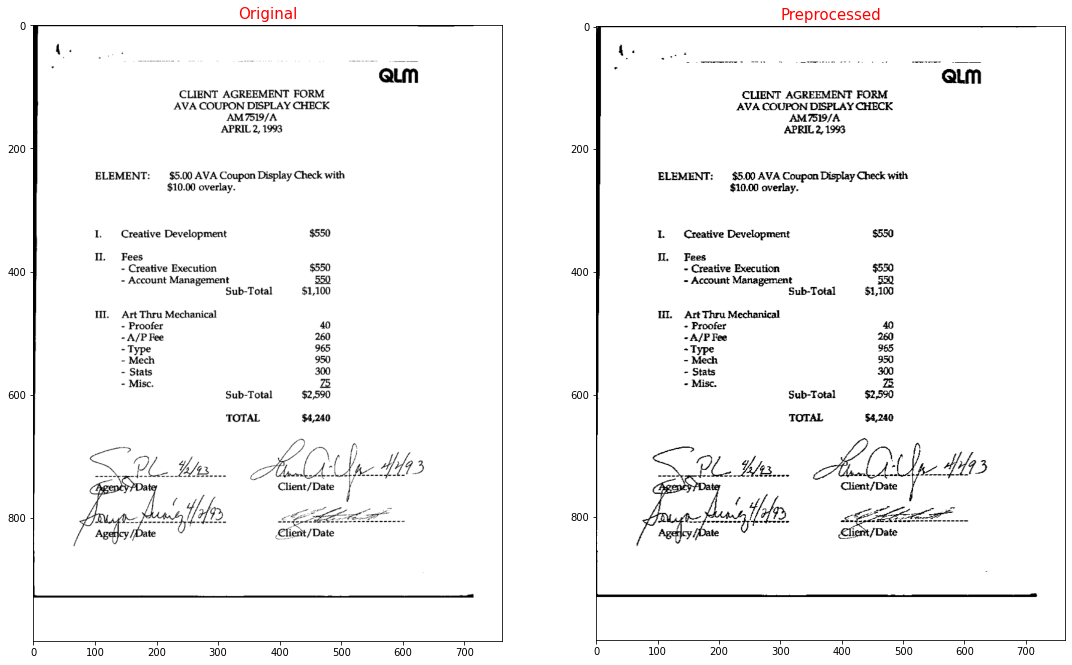

In [ ]:
show_2_images(img, img_preprocessed, img_titles=['Original', 'Preprocessed'])

In [ ]:
del fn, img, img_preprocessed

### Create Target Using XML data
These code will see what kind of data provided under .xml format 


In [ ]:
# The structure of xml(for our interest) is:
# <TextRegion>
#     <TextLine>
#         <Word>
#             <Unicode> Text </Unicode>
#         </Word>
#     </TextLine>
# </TextRegion>

In [ ]:
# import os
# for dirname, _, filenames in os.walk(filepath):
#     filepath = dirname
#     list_filename = filenames

In [ ]:
import fnmatch
file_list = []
for file in ocrs:
    if fnmatch.fnmatch(file,'*_ocr.xml'):
        file_list.append(file) 

In [ ]:
from lxml import etree, objectify

parser = etree.XMLParser(remove_blank_text=True)
tree = etree.parse(os.path.join(filepath,file_list[0]))
root = tree.getroot()

#This file contains xml name space which come attached with each tag, 
#xmlns makes it difficult for a reader to focus on desired tag, so we remove the namespaces
for elem in root.getiterator():
    if not hasattr(elem.tag, 'find'): continue  
    i = elem.tag.find('}')
    if i >= 0:
        elem.tag = elem.tag[i+1:]
objectify.deannotate(root, cleanup_namespaces=True)

In [ ]:
#all the tag in xml are added to tag_list 
tag_list = []
for element in root.iter():
    tag_list = element.tag

In [ ]:
import re
prev_block_Page = ''
prev_block_Block = ''
prev_block_Line = ''
prev_block_Word = ''
sentence = ''
sentence2 = ''
sentence3 = ''
block = []
line = []
for element in root.iter('Unicode'):
    same_page = same_block = same_line = next_word = False
    parent_node = next(element.iterancestors('Word'))
    block_list = parent_node.attrib['id'].split('_')
    if(prev_block_Page == block_list[0] or prev_block_Page == ''):
        same_page = True
    if(prev_block_Block == block_list[1] or prev_block_Block == ''):
        same_block = True        
    if(prev_block_Line == block_list[2] or prev_block_Line == ''):
        same_line = True
    if(prev_block_Word == int(block_list[3][1:])-1 or prev_block_Word == ''):
        next_word = True
                    
    #only same line present in one sentnece:
    #Here we check if the sentence contains the keywords which we are looking for like 'Date'
    if same_line and same_block:
        sentence3 = sentence3 + re.sub("[^0-9a-zA-Z:,]+", ' ',element.text) + ' ' 
    else:
        line.append(sentence3)
        sentence3 = ''
        sentence3 = sentence3 + re.sub("[^0-9a-zA-Z:,]+", ' ',element.text)+ ' '
    
    #same block in one line:
    if same_block:
        sentence = sentence + re.sub("[^0-9a-zA-Z:,]+", ' ',element.text) + ' '
    else:
        block.append(sentence)
        sentence = ''
        sentence = sentence + re.sub("[^0-9a-zA-Z:,]+", ' ',element.text)+ ' '  
      
    #all text in same line:
    sentence2 = sentence2 + re.sub("[^0-9a-zA-Z:,]+", ' ',element.text) + ' '
        
    prev_block_Page = block_list[0]
    prev_block_Block = block_list[1]
    prev_block_Line = block_list[2]
    prev_block_Word = int(block_list[3][1:])
print(line)
print(block)    
print(sentence2)

['r  ', 'B AT  U K  and EXPORT  limited ', 'Export House Woking Surrey GU211YB England ', 'Brown   Williamson International Tobacco, ', '3000 First National Tower, ', '101 South Fifth Street, ', 'Louisville, Kentucky 40202, ', 'U S A  ', 'Attention Mr  Gory Xhirschncr ', 'Telephone Wokin  76111 ', 'Telaeriphic Addreee Export Wokir  ', 'Telex  M101 ', 'VAT Reg  No  239136S to ', 'Invoice No  ', 'N I8l6 ', 'Date  Tax Point  ', '26 5 02 ', 'By debit in respect of:  ', ' llalf of Counter Deal charges ', 'in 1981 in excess of your earlier ', 'estimate  Geoff Harper s telex ', 'of 25 5 82 refers  ', '  1 80 ']
['r  ', 'B AT  U K  and EXPORT  limited Export House Woking Surrey GU211YB England ', 'Brown   Williamson International Tobacco, 3000 First National Tower, 101 South Fifth Street, Louisville, Kentucky 40202, U S A  Attention Mr  Gory Xhirschncr ', 'Telephone Wokin  76111 Telaeriphic Addreee Export Wokir  Telex  M101 VAT Reg  No  239136S to ', 'Invoice No  ', 'N I8l6 ', 'Date  Tax Point

In [ ]:
filename = 'beautiful_data.txt'
write_txt_to_file = open(filename,'a')
write_txt_to_file.write(sentence2)
write_txt_to_file.close()

In [ ]:
import csv
field = ['TEXT']
row = sentence
filename = 'beautiful_data.csv'
with open(filename,'a',newline='') as csvfile:
    csvwriter = csv.writer(csvfile)#creates an object for writing in csv files
    csvwriter.writerow(sentence)

In [ ]:
txt_filename = 'beautiful_data_summary.txt'
for xml_file in file_list:
    parser = None
    root = None
    tree = None
    new_sentence = ''
    parser = etree.XMLParser(remove_blank_text=True)
    xml_file_path = os.path.join(filepath, xml_file)
    tree = etree.parse(xml_file_path)
    root = tree.getroot()
    #remove the namespaces
    for elem in root.getiterator():
        if not hasattr(elem.tag, 'find'): continue  
        i = elem.tag.find('}')
        if i >= 0:
            elem.tag = elem.tag[i+1:]
    objectify.deannotate(root, cleanup_namespaces=True)
    
    for element in root.iter('Unicode'):
        new_sentence = new_sentence + re.sub("[^0-9a-zA-Z:,]+", ' ',element.text) + ' '
    #print('new_sentence = '+new_sentence)    
    #writing the new_sentence in the file 
    wrtie_txt_to_file = None
    write_txt_to_file = open(txt_filename,'a')
    write_txt_to_file.write(new_sentence)
    write_txt_to_file.write('\n')
    write_txt_to_file.close()

In [ ]:
import pandas as pd
pd.set_option('display.max_colwidth',3000)
dfx = pd.read_csv('./beautiful_data_summary.txt',delimiter='/n',header=None)
dfx.columns = ['extracted_text']
# dfx.head(7)

<ipython-input-100-973a08213581>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  dfx = pd.read_csv('./beautiful_data_summary.txt',delimiter='/n',header=None)


extracted_text
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         r  B AT  U K  and EXPORT  limited Export House Woking Surrey GU211YB England Brown   Williamson International Tobacco, 3000 First National Tower, 101 South Fifth Street, Louisville, Kentucky 40202, U S A  Attention Mr  Gory Xhirschncr Telephone Wokin  76111 Telaeriphic Addreee Export Wokir  Telex  M101 VAT Reg  No  239136S to Invoice No  N I8l6 Date  Tax Point  26 5 02 By debit in respect of:   llalf of Counter Deal charges in 1981 in excess of your earlier estimate  Geoff Harper s telex of 25 5 82 refers    1 80 US 13,600 00
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Tod Bata  a company, inc  advertising  JiJI t  r YOfk ICC so Ul   aoi   cut    YT  PRCOuCUCN ESTIMATE REPORT AC19 HILLINO JYPt PROGRESSIVE PIN CM APR21 7  AI 16 38 PACE 1 CflENI OH BkOMN 6 WILLIAHSON IOBACCC COAP    xicr  i R001 RtvIA P PA IN I PBOON JOP PH1B04 LIKE  EM LQNC PUT MATE  EH STRONG KM PR T 7 3 K H 76 98 CQMH  VERT L SPR LN6S H f MGS BILLING 1600 h Hilt ST 1977 T IM1 F SSFNCE TV GUIDE JET MC CALL S 9 C BUI AGORESS LOUISVILLE K  90201 PHQTuG ALPmA PP 18267 ROAR CODE COMMISSION RATE ORIGINAL E S1I MATE RESENT ESTIMATE 09 PHDTOORPMAS PEE ZERO 1300 00 1300 00 C6 CLP PHNI OTE IP ZERO 229 00 225 00 C9 RETOUCHING ZERO 400 00 400 00 11 PHOTOSTATS ZERO 79 00 19 00  1   7 12 MECHANICALS ZERO 225 00 229 00 42 TRANSPARENCIES ZERO 190 00 150 00 49 TYPOGRAPHY ZERO 180 00 180 00 t   PRINTS ZERO 19 00 35 00 70 N t  SALES TAX ZERO 207 20 207 20 TOTALS 2797 20 2797 20 COMMISSIONS TOTALS 1 CROSS 1 2197 20 2797 20 j     Ata  TffM Au lf Ail Mini a  ra  7777  ti L OviTWCR PKJT 1 U E tfAK M C il  J wh1 rHICt rU 2 AT 825 k C 12 ALt MkUll KP  3 AI 875 M C 42 3 AT ASO CE IF THE FILM IMAfit IS LESS CLEAR I MIS HOT ICE  IT IS DUE TO THE  TTY OF THE DOCUMENT 0E1ICC  PI 1 0 0  66407 6 2 3 0
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Tod Botes a

In [ ]:
dfx['extracted_text'] = dfx['extracted_text'].apply(lambda x: str(x).lower())

In [ ]:
dfx.head()

extracted_text
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  r  b at  u k  and export  limited export house woking surrey gu211yb england brown   williamson international tobacco, 3000 first national tower, 101 south fifth street, louisville, kentucky 40202, u s a  attention mr  gory xhirschncr telephone wokin  76111 telaeriphic addreee export wokir  telex  m101 vat reg  no  239136s to invoice no  n i8l6 date  tax point  26 5 02 by debit in respect of:   llalf of counter deal charges in 1981 in excess of your earlier estimate  geoff harper s telex of 25 5 82 refers    1 80 us 13,600 00
1                                                              tod bata  a company, inc  advertising  jiji t  r yofk icc so ul   aoi   cut    yt  prcoucucn estimate report ac19 hillino jypt progressive pin cm apr21 7  ai 16 38 pace 1 cfleni oh bkomn 6 williahson iobaccc coap    xicr  i r001 rtvia p pa in i pboon jop ph1b04 like  em lqnc put mate  eh strong km pr t 7 3 k h 76 98 cqmh  vert l spr ln6s h f mgs billing 1600 h hilt st 1977 t im1 f ssfnce tv guide jet mc call s 9 c bui agoress louisville k  90201 phqtug alpma pp 18267 roar code commission rate original e s1i mate resent estimate 09 phdtoorpmas pee zero 1300 00 1300 00 c6 clp phni ote ip zero 229 00 225 00 c9 retouching zero 400 00 400 00 11 photostats zero 79 00 19 00  1   7 12 mechanicals zero 225 00 229 00 42 transparencies zero 190 00 150 00 49 typography zero 180 00 180 00 t   prints zero 19 00 35 00 70 n t  sales tax zero 207 20 207 20 totals 2797 20 2797 20 commissions totals 1 cross 1 2197 20 2797 20 j     ata  tffm au lf ail mini a  ra  7777  ti l ovitwcr pkjt 1 u e tfak m c il  j wh1 rhict ru 2 at 825 k c 12 alt mkull kp  3 ai 875 m c 42 3 at aso ce if the film imafit is less clear i mis hot ice  it is due to the  tty of the document 0e1icc  pi 1 0 0  66407 6 2 3 0
2  tod botes a company, inc  advertising 1515   he   r  n  vw  low  usa   211 m 31   c msbo mwo d n   or  pim w   w o tv tr i 34 prcaxiiuh nill iclicni bw tiu huhetk p 02 093a pace 1 uatc 0u1 aus2 79 bkj i  c williamsom ro acco corp  product km kgol milos  jjb pns0i2 koul milos pack pkesi ntaiiofj keoia p print proon tstlmafc hombtki km misc 78 iri bck code  n a 1600 m hill st loulsvillk ky 40701  ascription vcnoim nam  met amount commission total test copy prod 7cti0n 172176 pu nu 3936 thom ol samto 1500 00 i5uo oo 781011 po ho jtoo sh16 ikcoa 1000 00 1000 00 010479 po mo 4042 k c04  includes ifcxptmies for  1396 04 j  hooglpm tesa 1146 04 1146 04   112076 po mo 37 3 y c 4  in upts j  kjoolpm t2sa 7640 66 4 r  a n r r  2640 65 expenses for r :leasld  1140 6  au627t979  novk cum totals  6286 69 uckf  6266 69 uye transfer 7691  ao no 6452 au f ml 4ticolqr inc 1900 00 1930 00 26226 po no  030 gerry m1y3 6 associates 1625 00 1625 00  musk codt totals  3525 00 3525 00  stock photouphy 12526 po i b tom 250 00 26u oo yculyscmhanot   mcxk c60  tut  i s  250 oc 250 00 loc scout p ic  f y 010474 po mo ao 3 r  sio on 810 00  ootv 00    :ui uall 90ticl if tuf tllm  ai c ii iiss cl a2 3 s u or mrnt   ,t ,s   ro docwcift being riuco  66507 9 7 5 8
3                                   ted bates a company, inc advertising isis b e dw    w  t mh n  yon  11030  lj   oo  2 2 k6 3i3i   cobto:6ommr4  no  vo  run ota cct 1 7  79 at it so prcolcticn bill 8111 number v 10 u9

In [ ]:
import numpy as np
from keras.utils import to_categorical

# Example labels
labels = ["HELLO", "WORLD", "PYTHON", "Testing 1 as 12 Dec"]
labels = [i.lower() for i in labels]

# Define the alphabet
chars = ['abcdefghijklmnopqrstuvwxyz0123456789:, ']

# Create a dictionary to map characters to integers
char_to_int = dict((c, i) for i, c in enumerate(chars))

# Encode the labels using one-hot encoding
num_classes = len(chars)
y = []
for label in labels:
    label_vec = [0] * (num_classes * len(label))
    for i, char in enumerate(label):
        index = i * num_classes + char_to_int[char]
        label_vec[index] = 1
    y.append(label_vec)

y = np.array(y)


TypeError: ignored

### [Modelling](https://medium.com/analytics-vidhya/image-text-recognition-738a368368f5)
The Model used for the problem is called Convolutional Recurrent Neural Network (CRNN) since it combines Deep Convolutional Neural Networks (DCNN) and RNN which constructs an end-to-end system for sequence recognition. The Model consists of three components, including the convolutional layers, the recurrent layers, and a transcription layer. The convolutional layers automatically extract a feature sequence from each input image. On top of the convolutional network, a recurrent network is built for making prediction for each frame of the feature sequence, outputted by the convolutional layers. The transcription layer at the top of CRNN is adopted to translate the per-frame predictions by the recurrent layers into a label sequence. Though CRNN is composed of different kinds of network architectures (DCNN and RNN), it can be jointly trained with one loss function.

CNN Model Example Code here:

In [ ]:
# CNN model example

# from keras.models import Sequential
# from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# # Define the input shape of the image
# input_shape = (height, width, channels)

# # Create a Sequential model
# model = Sequential()

# # Add Convolutional layers
# model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# # Add Fully Connected layers
# model.add(Flatten())
# model.add(Dense(units=128, activation='relu'))
# model.add(Dense(units=num_classes, activation='softmax'))

# # Compile the model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Print the model summary
# model.summary()


In [ ]:
# import numpy as np
# from keras.utils import to_categorical

# # Example labels
# labels = ["HELLO", "WORLD", "PYTHON"]

# # Define the alphabet
# alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

# # Create a dictionary to map characters to integers
# char_to_int = dict((c, i) for i, c in enumerate(alphabet))

# # Encode the labels using one-hot encoding
# num_classes = len(alphabet)
# y_train = []
# for label in labels:
#     label_vec = [0] * (num_classes * len(label))
#     for i, char in enumerate(label):
#         index = i * num_classes + char_to_int[char]
#         label_vec[index] = 1
#     y_train.append(label_vec)

# y_train = np.array(y_train)
